In [1]:
import numpy as np
import unfolding
from unfolding._utils import dummy, half_sphere
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'Dummy label')

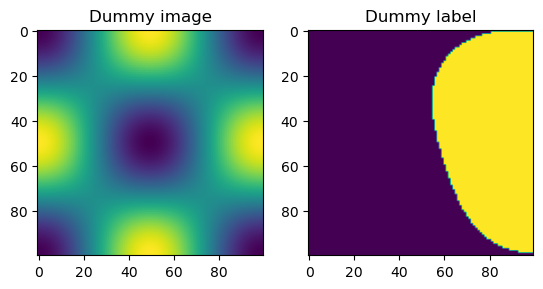

In [2]:
image, label = half_sphere()

plt.subplot(121)
plt.imshow(image[50])
plt.title("Dummy image")
plt.subplot(122)
plt.imshow(label[50])
plt.title("Dummy label")

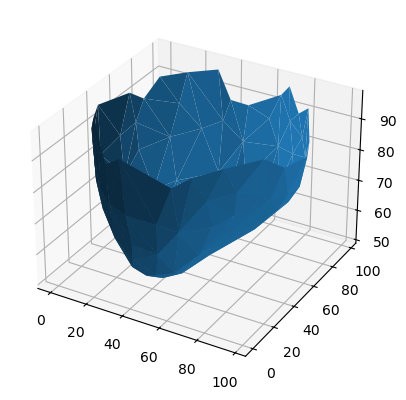

In [3]:
verts, faces = unfolding.create_simplified_tessellation(label, 100)

ax = plt.figure().add_subplot(projection="3d")
ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces)

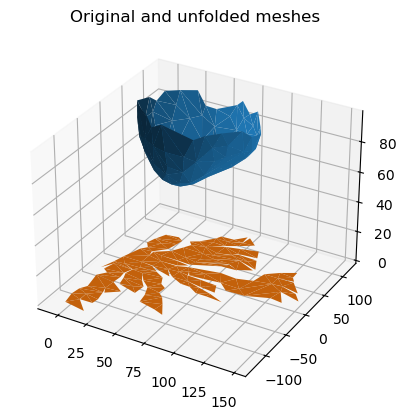

In [4]:
verts_2d, faces_2d, dict_2d_3d = unfolding.unfold_tessellation(
    verts, faces, base_triangle=0, draw=0
)

verts_2d = np.stack(verts_2d)
verts = np.stack(verts)
ax = plt.figure().add_subplot(projection="3d")
ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces)
ax.plot_trisurf(verts_2d[:, 0], verts_2d[:, 1], 0 * verts_2d[:, 1], triangles=faces_2d)
plt.title("Original and unfolded meshes");

In [5]:
# unfold and extract layers
layers = unfolding.unfolded_layers(
    verts, faces, verts_2d, faces_2d, dict_2d_3d, image, n_layers=5
)

100%|██████████| 175/175 [00:24<00:00,  7.27it/s]


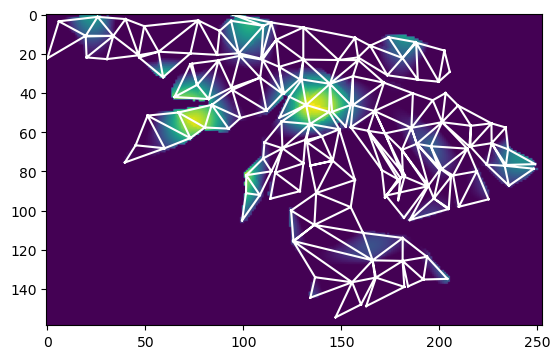

In [6]:
plt.imshow(layers[..., 5])
plt.triplot(verts_2d[:, 1] - verts_2d[:,1].min(), verts_2d[:, 0] - verts_2d[:,0].min(), triangles=faces_2d, color="w")

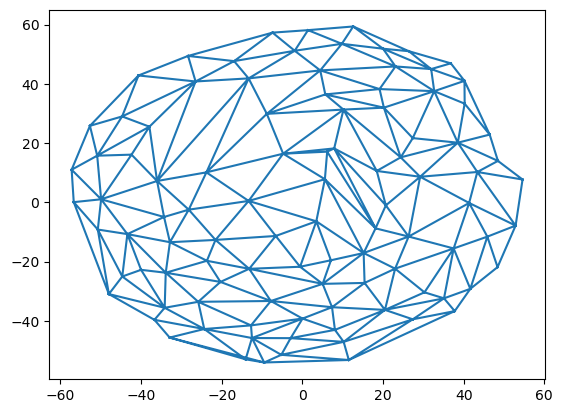

In [7]:
from sklearn.manifold import MDS

embedding = MDS(n_components=2, metric=True, normalized_stress="auto")
verts_2d_mds = embedding.fit_transform(verts)
plt.triplot(verts_2d_mds[:, 1], verts_2d_mds[:, 0], triangles=faces)

In [8]:
# # unfold and extract layers
# layers = unfolding.unfolded_layers(
#     verts, faces, verts_2d_mds, faces, dict_2d_3d_mds, image, n_layers=5
# )

# plt.imshow(layers[..., 5])
# plt.triplot(
#     verts_2d_mds[:, 1] + 145, verts_2d_mds[:, 0] + 140, triangles=faces, color="w"
# )

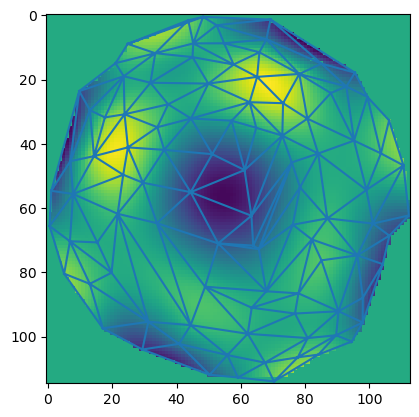

In [11]:
from scipy import ndimage as ndi
from scipy import interpolate
from math import floor, ceil



def point_in_triangle(point, triangle):
    # https://stackoverflow.com/questions/2049582/how-to-determine-if-a-point-is-in-a-2d-triangle
    # Unpack arguments
    x, y = point
    ax, ay = triangle[0]
    bx, by = triangle[1]
    cx, cy = triangle[2]
    # Segment A to B
    side_1 = (x - bx) * (ay - by) - (ax - bx) * (y - by)
    # Segment B to C
    side_2 = (x - cx) * (by - cy) - (bx - cx) * (y - cy)
    # Segment C to A
    side_3 = (x - ax) * (cy - ay) - (cx - ax) * (y - ay)
    # All the signs must be positive or all negative
    return (side_1 < 0.0) == (side_2 < 0.0) == (side_3 < 0.0)


def points_in_triangle(grid, triangle):
    """
    grid: ndarray (N,3)
    triangle: ndarray (3,2)
    """
    # find points in the triangle bounding box
    lower = np.min(triangle, axis=0)
    upper = np.max(triangle, axis=0)
    idx = np.logical_and(
        np.all(grid[:, :2] > lower, axis=1), np.all(grid[:, :2] < upper, axis=1)
    )
    # find points in the triangle
    points = [p for p in grid[idx] if point_in_triangle(p[:2], triangle)]
    if len(points) > 0:
        return np.stack(points)
    else:
        return None

def point_2d_to_3d(x, t1, t2):
    """
    Map a 2d point in 2d triangle to a 3d point in the 3d triangle
    
    Parameters
    ----------
    point2d: ndarray (2,)
    triangle2d: ndarray (3,2)
    triangle2d: ndarray (3,3)

    Returns
    -------
    point3d: ndarray (N,3)
    """

    P = np.stack((t1[1]-t1[0],t1[2]-t1[0],np.cross(t1[1]-t1[0],t1[2]-t1[0])),axis=1)
    Q = np.stack((t2[1]-t2[0],t2[2]-t2[0],np.cross(t2[1]-t2[0],t2[2]-t2[0])),axis=1)
    return t2[0] + Q@np.linalg.inv(P)@(x-t1[0])
    
def points_2d_to_3d(points, t1, t2):
    return np.array([point_2d_to_3d(x, t1, t2) for x in points])

def peel_layers(image, verts3d, faces3d, verts2d, faces2d=None, layers=np.arange(-3, 3, 1)):
    """

    src: ndarray
    verts3d: ndarray (N,3)
    faces3d: ndarray (M,3)
    verts2d: ndarray (K,2)
    faces2d: ndarray (M,3) | None

    """
    if faces2d is None:
        faces2d = faces3d
    # compute the shape of the accumulators
    lower = np.floor(np.min(verts2d, axis=0)).astype(int) 
    upper = np.ceil(np.max(verts2d, axis=0)).astype(int) 
    bbox = upper - lower
    shape = [bbox[1], bbox[0], len(layers)]  # yxz
    acc1 = np.zeros(shape)
    acc2 = np.zeros(shape)
    # compute the xyz grid as N x[x,y,z]
    grid = np.stack(
        [x.ravel() for x in np.meshgrid(*[np.arange(n) for n in shape], indexing="xy")],
        0,
    ).T
    # For each 2d triangle
    for face2d, face3d in zip(faces2d, faces3d):
        # compute the coordinates of the 2d triangle        
        triangle2d = np.zeros((3,3))
        triangle2d[:,:2] = verts2d[face2d, :] - lower
        # list points [xyz] of the grid inside the 2d triangle
        dst = points_in_triangle(grid, triangle2d[:,:2])
        if dst is not None:
            # compute the coordinates of the 3d triangle
            triangle3d = verts3d[face3d, :]
            # get 3d points the corresponding matching 2d points
            src = points_2d_to_3d(dst, triangle2d, triangle3d)
            # convert xyz to yxz
            coords = src[:,[1,0,2]].T
            # get the values in the initial image
            values = ndi.map_coordinates(image, coords)
            # add the value in the accumulator
            acc1[dst[:, 1], dst[:, 0], dst[:, 2]] += values
            acc2[dst[:, 1], dst[:, 0], dst[:, 2]] += values > 0
    acc1[acc2 > 1] /= acc2[acc2 > 1]
    return acc1


layers = peel_layers(image, verts, faces, verts_2d_mds, faces)
plt.imshow(layers[..., 0].T)
plt.triplot(verts_2d_mds[:, 1]-verts_2d_mds[:,1].min()+0.5, verts_2d_mds[:, 0]-verts_2d_mds[:,0].min()+0.5, triangles=faces)

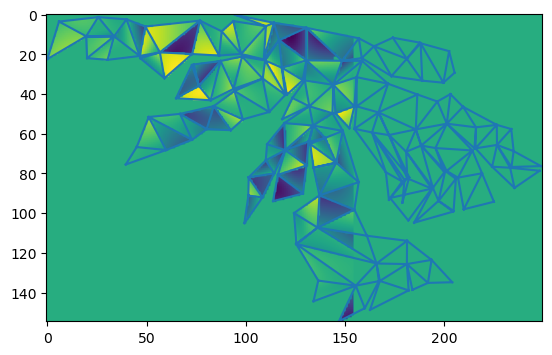

In [12]:
layers = peel_layers(image, verts, faces, verts_2d, faces_2d)
plt.imshow(layers[..., 0].T)
plt.triplot(verts_2d[:, 1] - verts_2d[:,1].min(), verts_2d[:, 0] - verts_2d[:,0].min(), triangles=faces_2d)


In [228]:
img = np.arange(12).reshape(3, 4)
pts = np.array([[0.5, 0.5], [0.5, 1.5], [0.5, 2.5]]).T
print(pts.shape)
ndi.map_coordinates(img, pts)

(2, 3)


array([2, 3, 4])

array([[1, 1],
       [1, 1]])

(array([2.50000000e-01, 2.50000000e-01, 2.60853249e-17]),
 array([0.25, 0.25, 0.  ]))

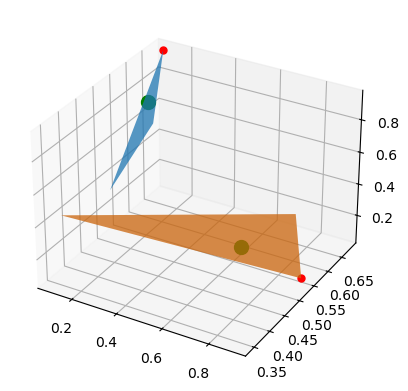

In [23]:
from matplotlib import pyplot as plt
import numpy as np
# verts_2d = np.array([[0,0],[0,1],[1,0]])
# faces = np.array([0,1,2])
# plt.triplot(verts_2d,faces)

triangle2d = np.array([[0,0],[1,0],[0,2]])
triangle3d = np.array([[0,0,0],[0,0,2],[0,2,0]])
point2d = np.array([[1, 1, 0]]).T
# P = point2d_to_3d(point2d, triangle2d, triangle3d)
# to the 2d triangle basis
#P = np.eye(3,3)
#P[:2,:2] = np.stack((triangle2d[1]-triangle2d[0], triangle2d[2]-triangle2d[0]))
# to 3d space
# Q = np.stack((triangle3d[1]-triangle3d[0], triangle3d[2]-triangle3d[0])).T
X = point2d
# X[:2,:] -= triangle2d[0]
#triangle3d[0]+(Q@np.linalg.inv(P)@X).T


v1 = np.random.uniform(size=(3,3))
v2 = np.random.uniform(size=(3,3))
e = np.array([0,1,2])
t1 = v1[e]
t2 = v2[e]
#u,v = np.random.rand(),np.random.rand()
uv = np.array([0.25,0.25,0])

P = np.stack((t1[1]-t1[0],t1[2]-t1[0],np.cross(t1[1]-t1[0],t1[2]-t1[0])),axis=1)
Q = np.stack((t2[1]-t2[0],t2[2]-t2[0],np.cross(t2[1]-t2[0],t2[2]-t2[0])),axis=1)
x1 = t1[0] + P@uv
x2 = t2[0] + Q@np.linalg.inv(P)@(x1-t1[0])

#plt.triplot(v[:,0],v[:,1],triangles=e)

#ax.plot_trisurf(verts_2d[:, 0], verts_2d[:, 1], 0 * verts_2d[:, 1], triangles=faces_2d)
ax = plt.subplot(projection='3d')
ax.plot_trisurf(v1[:, 0], v1[:, 1], v1[:, 2], triangles=e,alpha=0.75)
ax.plot(x1[0],x1[1],x1[2],'go',ms=10)
ax.plot(t1[0,0],t1[0,1],t1[0,2],'ro',ms=5)
ax.plot_trisurf(v2[:, 0], v2[:, 1], v2[:, 2], triangles=e,alpha=0.75)
ax.plot(t2[0,0],t2[0,1],t2[0,2],'ro',ms=5)
ax.plot(x2[0],x2[1],x2[2],'go',ms=10)
np.linalg.inv(P)@(x1-t1[0]), uv


In [92]:
(t1[1]-t1[0])

array([ 0.3841599 ,  0.11933773, -0.28964645])

In [29]:
(triangle3d[0] + Q@np.linalg.inv(P)@(point2d-triangle2d[0]).T).T



array([[0., 1., 1.],
       [0., 1., 1.],
       [0., 0., 0.]])